# 관광지 추천점수 산정 


1. 관광지 추천점수 산정 로직 (5점 척도)
- eco_rate : 바람지도/푸른컵 등 친환경 사업 여부 1 or 0
- co2_rate : 건물에 대한 탄소 배출량 스케일
- review_rate : 네이버 블로그 수 스케일
- cluster_rate : 구역의 특성과 일치하는 정도
- dist_rate : 선별된 F&B와의 거리


In [1]:
import pandas as pd
import folium
import numpy as np
import os
import random
import re

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from haversine import haversine
from sklearn.preprocessing import minmax_scale


In [2]:
data = pd.read_csv('data/관광지_유사도.csv', encoding='utf-8-sig') 

In [3]:
category = pd.read_csv('data/관광지_구역배정.csv', encoding='utf-8-sig') 
category = category[['name_PRE','CL_NM','CAT_PRE','PREICE_MAX']]
category.columns = ['name_PRE','CL_NM','CAT_PRE','price']
category.price[category.price.isna()] = 0

data = pd.merge(left=data, right=category, how="left", on = "name_PRE")
data = data[['cluster', 'CL_NM', 'CAT_PRE','name_PRE', 'lon', 'lat','price','blog_review_num_list','co2_max', 'similarity']]
data['type'] = "관광지"
data

,cluster,CL_NM,CAT_PRE,name_PRE,lon,lat,price,blog_review_num_list,co2_max,similarity,type
0,0,테마관광지,테마파크/공연/전시,감귤박물관,126.607428,33.271593,0.0,886.0,0.023639,0.403927,관광지
1,4,공연전시,테마파크/공연/전시,건강과성박물관,126.346584,33.254847,0.0,542.0,0.507125,0.501137,관광지
2,1,공연전시,테마파크/공연/전시,고흐의정원,126.844086,33.373409,0.0,373.0,0.021090,0.290487,관광지
3,1,레저관광,레저/체험,김녕요트투어,126.737260,33.558248,0.0,490.0,0.282392,0.268219,관광지
4,3,공연전시,테마파크/공연/전시,노형수퍼마켙,126.455168,33.464942,0.0,2161.0,0.403384,0.508015,관광지
...,...,...,...,...,...,...,...,...,...,...,...
874,5,쇼핑,시장,한림민속오일시장,126.274504,33.419832,0.0,336.0,0.305565,0.137163,관광지
875,5,쇼핑,특산물,한마음한라봉,126.318030,33.466498,0.0,0.0,0.878523,0.152665,관광지
876,3,쇼핑,시장,함덕민속오일시장,126.667961,33.540253,0.0,54.0,0.024546,0.244736,관광지
877,5,쇼핑,특산물,현승이네농장,126.378786,33.463614,0.0,1.0,0.878523,0.126018,관광지


## 1. eco_rate : 친환경 사업 여부

In [4]:
baram = pd.read_csv('data/제주바람지도.csv', encoding='utf-8-sig')
bluecup = pd.read_csv('data/제주푸른컵지도.csv', encoding='utf-8-sig')

In [5]:
# 이름 전처리용
def name_preprocessing(name):
    name = name.replace(' (', '(').replace(') ', ')').strip()
    name = name.replace('(주)','').replace("·",".").lower()
    name = re.sub('[\(\)㈜!@#$%^&*{}|:;\'\"/><,~`+=_ ]','', name)
    name = re.sub('[\[.\]]','',name)
    return name.strip()

#주소 전처리용
def addr_preprocessing(addr):
    addr = re.sub('제주 서귀포시','제주특별자치도 서귀포시',addr)
    addr = re.sub('제주 제주시','제주특별자치도 제주시',addr)

    while (addr.split()[-1][-1].isdigit() == False) : #상세주소 제거
        if len(addr.split()) <= 3 : break
            
        addr = " ".join(addr.split()[0:-1]) #하나빼기

    addr = "".join(addr.split()) #공백다 없애기
    return addr.strip() #앞뒤정리

In [6]:
baram

,장소 이름,전화번호,인스타그램,상세설명,분류
0,용머리해안 기후변화홍보관,064.792.6077,NaN,기후변화에 따른 해수면 상승 현상 체감하기,환경교육&체험
1,㈜푸른바이크쉐어링 자전거 학교 'BY 100',064.721.0333,NaN,자전거 이용 문화 확산을 위한 교육부터 숙박 체험까지,환경교육&체험
2,제주물사랑홍보관,064.710.4098,NaN,"제주도 물의 역사, 문화, 순환과정 살펴보기",환경교육&체험
3,3R+센터 에코체험센터,064.722.9401,NaN,자원절약과 폐기물 자원화의 소중함 배우기,환경교육&체험
4,CFI에너지미래관,064.720.7490,NaN,제주의 청정에너지를 오감으로 체험하기,환경교육&체험
...,...,...,...,...,...
57,카페스물다섯,064.748.3334,25__twentyfive,에너지 소통 공감 카페에서 기후위기에 대해 생각해 봐요,제로플라스틱 실천
58,제주민박 소로소로,010.3679.9938,sorosoro_jeju,다양한 다회용 어메니티가 준비되어 있어요,제로플라스틱 실천
59,한라서적타운,064.722.7722,hallabooktown,서점 안에 제로웨이스트 소개 코너가 있어요,제로플라스틱 실천
60,수놀음알뜰가게 요디,064.752.5382,NaN,"쓰지 않는 물건은 기증하고, 자원 재순환을 실천해요",제로플라스틱 실천


In [7]:
baram.columns = ['area_name', 'tel', 'instagram', 'detail', 'category']

In [8]:
data

,cluster,CL_NM,CAT_PRE,name_PRE,lon,lat,price,blog_review_num_list,co2_max,similarity,type
0,0,테마관광지,테마파크/공연/전시,감귤박물관,126.607428,33.271593,0.0,886.0,0.023639,0.403927,관광지
1,4,공연전시,테마파크/공연/전시,건강과성박물관,126.346584,33.254847,0.0,542.0,0.507125,0.501137,관광지
2,1,공연전시,테마파크/공연/전시,고흐의정원,126.844086,33.373409,0.0,373.0,0.021090,0.290487,관광지
3,1,레저관광,레저/체험,김녕요트투어,126.737260,33.558248,0.0,490.0,0.282392,0.268219,관광지
4,3,공연전시,테마파크/공연/전시,노형수퍼마켙,126.455168,33.464942,0.0,2161.0,0.403384,0.508015,관광지
...,...,...,...,...,...,...,...,...,...,...,...
874,5,쇼핑,시장,한림민속오일시장,126.274504,33.419832,0.0,336.0,0.305565,0.137163,관광지
875,5,쇼핑,특산물,한마음한라봉,126.318030,33.466498,0.0,0.0,0.878523,0.152665,관광지
876,3,쇼핑,시장,함덕민속오일시장,126.667961,33.540253,0.0,54.0,0.024546,0.244736,관광지
877,5,쇼핑,특산물,현승이네농장,126.378786,33.463614,0.0,1.0,0.878523,0.126018,관광지


In [9]:
eco_list = []
        
#이름이 일치하는 경우
name_list = list(map(lambda x : name_preprocessing(x), baram['area_name']))
set(eco_list).union(set(data[data['name_PRE'].isin(name_list)].index))

#포함되는 경우
for i in range(0, len(name_list)) :
    idx = data[data['name_PRE'].str.contains(name_list[i])].index
    if len(idx) >0 :
        eco_list.append(idx.values[0])

for i in range(0, len(data)) :
    if len(baram[baram['area_name'].str.contains(data.name_PRE[i])]) >0 : 
        eco_list.append(i)

In [10]:
bluecup.head()

,이름,설명,분류
0,그레이그로브,푸른컵 10% 할인,푸른컵 카페
1,까페 제주동네,푸른컵 500원 할인,푸른컵 카페
2,돌랑돌랑상점 제주공항점,푸른컵 20% 할인,푸른컵 카페
3,더 리트리브,푸른컵 20% 할인,푸른컵 카페
4,라임오렌지카페앤플라워,푸른컵 500원 할인,푸른컵 카페


In [11]:
#이름이 일치하는 경우
name_list = list(map(lambda x : name_preprocessing(x), bluecup['이름']))
set(eco_list).union(set(data[data['name_PRE'].isin(name_list)].index))

# 초함되는 경우
for i in range(0, len(name_list)) :
    idx = data[data['name_PRE'].str.contains(name_list[i])].index
    if len(idx) >0 :
        eco_list.append(idx.values[0])

for i in range(0, len(data)) :
    if len(bluecup[bluecup['이름'].str.contains(data.name_PRE[i])]) >0 : 
        eco_list.append(i)

In [12]:
eco_list

[250, 827, 23, 250, 827, 856, 311, 311, 311]

In [13]:
#중복제거 및 처리
eco_list = set(eco_list)
data.iloc[list(eco_list)]

,cluster,CL_NM,CAT_PRE,name_PRE,lon,lat,price,blog_review_num_list,co2_max,similarity,type
23,4,자연,자연,용머리해안,126.314631,33.233482,0.0,4825.0,0.005309,0.139690,관광지
311,1,NaN,레저/체험,빠우사,126.711909,33.457740,0.0,8.0,0.007189,0.089769,관광지
856,3,쇼핑,특산물,이제주숍,126.540713,33.499434,0.0,16.0,1.241532,0.168371,관광지
250,5,NaN,레저/체험,물뫼힐링팜,126.396556,33.464249,0.0,15.0,0.366539,0.147966,관광지
827,5,쇼핑,기념품/소품,베리제주,126.336327,33.466620,0.0,431.0,0.118939,0.257585,관광지


In [14]:
data['eco_YN'] = 0
data['eco_YN'].iloc[list(eco_list)] = 1

## 2. co2_rate : 건물에 대한 탄소배출량 스케일 점수

In [15]:
data['co2_rate'] = (1 - minmax_scale(data['co2_max'],copy=True)).tolist()

In [16]:
data['co2_rate'].sort_values()

666    0.000000
426    0.557412
367    0.557412
624    0.734474
862    0.772791
         ...   
690    0.999996
216    1.000000
513    1.000000
361    1.000000
154    1.000000
Name: co2_rate, Length: 879, dtype: float64

<AxesSubplot:xlabel='co2_rate', ylabel='Density'>

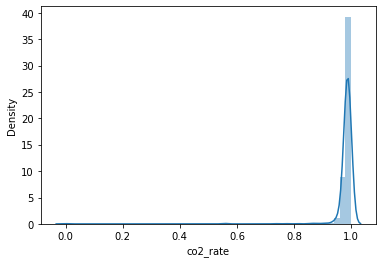

In [17]:
import seaborn as sns
sns.distplot(data['co2_rate'])

## 3. review_rate : 네이버 블로그 수

In [18]:
data['review_rate'] = minmax_scale(data['blog_review_num_list'],copy=True).tolist()

In [19]:
data['review_rate'].sort_values()

648    0.000000
27     0.000000
493    0.000000
492    0.000000
849    0.000000
         ...   
784    0.861742
360    0.922018
771    0.922018
22     0.977789
373    1.000000
Name: review_rate, Length: 879, dtype: float64

<AxesSubplot:xlabel='review_rate', ylabel='Density'>

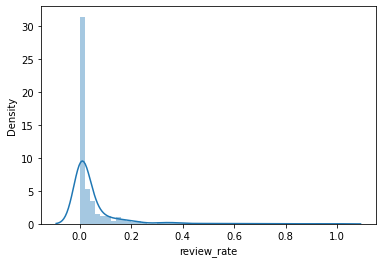

In [20]:
sns.distplot(data['review_rate'])

## 4. dist_rate : 선정된 F&B와의 접근성

#### 4-(1) F&B 클러스터 정보 병합

In [21]:
# FB 데이터 클러스터 정보 병합
FB = pd.read_csv('data/F&B추천점수.csv')
cluster_info = pd.read_csv("data/데이터_제주구역배정.csv")
fb_cluster = cluster_info[cluster_info['type']=="fnb"].reset_index()

In [22]:
FB = pd.merge(FB, fb_cluster[['AREA_NM_PRE', 'cluster']], how="left", on = "AREA_NM_PRE")

In [23]:
# 클러스터0
cluster0 = FB[FB['cluster']== 0].sort_values('rec_score', ascending=False)

# 식당
food0 = cluster0[cluster0.category != "카페/디저트"].head(8).reset_index(drop=True)
# 카페/디저트 
cafe0 = cluster0[(cluster0.category == "카페/디저트")].head(4).reset_index(drop=True)

In [24]:
cluster0_final = pd.concat([food0, cafe0])
cluster0_final = cluster0_final.reset_index(drop=True)

In [25]:
# 클러스터 1
cluster1 = FB[FB['cluster']== 1].sort_values('rec_score', ascending=False)

# 식당
food1 = cluster1[cluster1.category != "카페/디저트"].head(8).reset_index(drop=True)
# 카페/디저트 
cafe1 = cluster1[(cluster1.category == "카페/디저트")].head(4).reset_index(drop=True)

In [26]:
cluster1_final = pd.concat([food1, cafe1])
cluster1_final = cluster1_final.reset_index(drop=True)

In [27]:
# 클러스터3
cluster3 = FB[FB['cluster']== 3].sort_values('rec_score', ascending=False)

# 식당
food3 = cluster3[cluster3.category != "카페/디저트"].head(10).reset_index(drop=True)

# 카페/디저트 
cafe3 = cluster3[(cluster3.category == "카페/디저트")].head(4).reset_index(drop=True)

In [28]:
cluster3_final = pd.concat([food3, cafe3])
cluster3_final = cluster3_final.reset_index(drop=True)

In [29]:
# 클러스터4
cluster4 = FB[FB['cluster']== 4].sort_values('rec_score', ascending=False)

# 식당
food4 = cluster4[cluster4.category != "카페/디저트"].head(8).reset_index(drop=True)

# 카페/디저트 
cafe4 = cluster4[(cluster4.category == "카페/디저트")].head(4).reset_index(drop=True)

In [30]:
cluster4_final = pd.concat([food4, cafe4])
cluster4_final = cluster4_final.reset_index(drop=True)

In [31]:
# 클러스터5 
cluster5 = FB[FB['cluster']== 5].sort_values('rec_score', ascending=False)

# 식당
food5 = cluster5[cluster5.category != "카페/디저트"].head(8).reset_index(drop=True)
# 카페/디저트 
cafe5 = cluster5[(cluster5.category == "카페/디저트")].head(6).reset_index(drop=True)

In [32]:
cluster5_final = pd.concat([food5, cafe5])
cluster5_final = cluster5_final.reset_index(drop=True)

#### 4-(2) 관광지별로 동일 구역 내 F&B와의 거리 계산

In [33]:
#클러스터별로 나누기
data0 = data[data.cluster==0].reset_index(drop=True)
data1 = data[data.cluster==1].reset_index(drop=True)
data3 = data[data.cluster==3].reset_index(drop=True)
data4 = data[data.cluster==4].reset_index(drop=True)
data5 = data[data.cluster==5].reset_index(drop=True)

In [34]:
# F&B선별 데이터
fnb0 = cluster0_final
fnb1 = cluster1_final
fnb3 = cluster3_final
fnb4 = cluster4_final
fnb5 = cluster5_final

In [35]:
#계산할 관광지 후보
def calcuate_dist(data,fnb):
    calcul_df = data[['name_PRE','lat','lon']]
    
    for i in range(0,len(fnb)):
        target = tuple(fnb[['lat','lon']].iloc[i])
        dist_list = []
    
        for j in range(0,len(calcul_df)):
            distance = haversine(target, tuple(calcul_df.iloc[j,1:3]), unit = 'km')
            dist_list.append(distance)
        calcul_df[f'{i}'] = dist_list
    #거리 최소값 계산
    calcul_df['dist_min'] = calcul_df.iloc[:,3:].min(axis=1)

    # 4km 이하인 거리는 모두 같은것(4km)으로 간주
    calcul_df['dist_min'][calcul_df['dist_min'] <= 4] = 4

    # Normalization > 점수부여
    data['dist_score'] = (1 - minmax_scale(calcul_df['dist_min'], copy=True)).tolist()

    return(data)

In [36]:
data0 = calcuate_dist(data0,fnb0)
data1 = calcuate_dist(data1,fnb1)
data3 = calcuate_dist(data3,fnb3)
data4 = calcuate_dist(data4,fnb4)
data5 = calcuate_dist(data5,fnb5)

In [37]:
data0

,cluster,CL_NM,CAT_PRE,name_PRE,lon,lat,price,blog_review_num_list,co2_max,similarity,type,eco_YN,co2_rate,review_rate,dist_score
0,0,테마관광지,테마파크/공연/전시,감귤박물관,126.607428,33.271593,0.0,886.0,0.023639,0.403927,관광지,0,0.999024,0.071302,0.530609
1,0,자연,자연,상효원,126.586009,33.307217,0.0,1129.0,0.310905,0.200666,관광지,0,0.987169,0.090858,0.546059
2,0,자연,자연,정방폭포,126.573050,33.244748,0.0,4427.0,0.092272,0.423816,관광지,0,0.996192,0.356269,0.668634
3,0,자연,자연,천지연폭포,126.559551,33.244717,0.0,5849.0,0.285718,0.357876,관광지,0,0.988209,0.470707,0.716300
4,0,키즈,테마파크/공연/전시,코코몽에코파크,126.708208,33.275160,0.0,1035.0,0.012029,0.247351,관광지,0,0.999504,0.083293,0.178004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0,쇼핑,시장,서귀포매일올레시장,126.563231,33.250149,0.0,8349.0,1.124130,0.147991,관광지,0,0.953608,0.671898,0.701053
131,0,쇼핑,시장,서귀포향토오일시장,126.572486,33.266877,0.0,873.0,0.218796,0.136813,관광지,0,0.990970,0.070256,0.655377
132,0,쇼핑,공방,아름낭,126.494643,33.258169,0.0,9.0,0.006108,0.150061,관광지,0,0.999748,0.000724,0.928442
133,0,쇼핑,기념품/소품,연필가게,126.744499,33.286167,0.0,114.0,0.009931,0.168674,관광지,0,0.999590,0.009174,0.043416


## 5.유사도 점수 


In [38]:
data['similarity']

0      0.403927
1      0.501137
2      0.290487
3      0.268219
4      0.508015
         ...   
874    0.137163
875    0.152665
876    0.244736
877    0.126018
878    0.224000
Name: similarity, Length: 879, dtype: float64

## 6. 관광지 최종 점수 산정

In [39]:
data0['total_score'] = data0[[ 'eco_YN', 'review_rate', 'co2_rate','dist_score', 'similarity']].sum(axis=1)
data0.sort_values(['total_score'],ascending = False )[:8]

,cluster,CL_NM,CAT_PRE,name_PRE,lon,lat,price,blog_review_num_list,co2_max,similarity,type,eco_YN,co2_rate,review_rate,dist_score,total_score
79,0,NaN,자연,엉또폭포,126.491918,33.258821,0.0,1864.0,0.032606,0.456621,관광지,0,0.998654,0.150008,0.936069,2.541352
3,0,자연,자연,천지연폭포,126.559551,33.244717,0.0,5849.0,0.285718,0.357876,관광지,0,0.988209,0.470707,0.716300,2.533091
130,0,쇼핑,시장,서귀포매일올레시장,126.563231,33.250149,0.0,8349.0,1.124130,0.147991,관광지,0,0.953608,0.671898,0.701053,2.474549
80,0,NaN,레저/체험,영실기암,126.466023,33.278536,0.0,111.0,0.366539,0.505567,관광지,0,0.984873,0.008933,0.947879,2.447252
2,0,자연,자연,정방폭포,126.573050,33.244748,0.0,4427.0,0.092272,0.423816,관광지,0,0.996192,0.356269,0.668634,2.444911
42,0,NaN,테마파크/공연/전시,법화사지,126.457602,33.265327,0.0,201.0,0.579984,0.421622,관광지,0,0.976064,0.016176,1.000000,2.413862
50,0,NaN,자연,서건도,126.498486,33.230077,0.0,199.0,0.310905,0.448216,관광지,0,0.987169,0.016015,0.931768,2.383168
86,0,NaN,테마파크/공연/전시,외돌개,126.545664,33.240077,0.0,2785.0,0.579984,0.402874,관광지,0,0.976064,0.224127,0.766464,2.369529


In [40]:
data1['total_score'] = data1[[ 'eco_YN', 'review_rate', 'co2_rate','dist_score', 'similarity']].sum(axis=1)
data1.sort_values(['total_score'],ascending = False )[:10]

,cluster,CL_NM,CAT_PRE,name_PRE,lon,lat,price,blog_review_num_list,co2_max,similarity,type,eco_YN,co2_rate,review_rate,dist_score,total_score
84,1,NaN,NaN,성산일출봉,126.936801,33.462234,NaN,12426.0,0.342912,0.437417,관광지,0,0.985848,1.000000,1.000000,3.423265
110,1,NaN,테마파크/공연/전시,아쿠아플라넷제주,126.927796,33.432977,0.0,9545.0,0.579984,0.286518,관광지,0,0.976064,0.768147,0.849852,2.880582
4,1,자연,자연,비자림,126.811461,33.491097,0.0,6956.0,0.244067,0.323949,관광지,0,0.989927,0.559794,0.916615,2.790286
120,1,NaN,자연,용눈이오름,126.852054,33.522527,0.0,4008.0,0.310905,0.477971,관광지,0,0.987169,0.322549,1.000000,2.787690
130,1,NaN,자연,월정리해변,126.798641,33.555113,0.0,6302.0,0.310905,0.288039,관광지,0,0.987169,0.507162,1.000000,2.782371
76,1,NaN,레저/체험,빠우사,126.711909,33.457740,0.0,8.0,0.007189,0.089769,관광지,1,0.999703,0.000644,0.668498,2.758614
18,1,NaN,자연,광치기해변,126.922403,33.437021,0.0,3897.0,0.055903,0.472380,관광지,0,0.997693,0.313617,0.864717,2.648407
32,1,NaN,자연,김녕해수욕장,126.736551,33.557208,0.0,4278.0,0.011501,0.265265,관광지,0,0.999525,0.344278,1.000000,2.609068
41,1,NaN,NaN,다랑쉬오름,126.862444,33.521649,NaN,1656.0,0.011491,0.424788,관광지,0,0.999526,0.133269,1.000000,2.557583
2,1,자연,자연,만장굴,126.771616,33.528377,0.0,3030.0,0.310905,0.312514,관광지,0,0.987169,0.243844,1.000000,2.543527


In [41]:
data3['total_score'] = data3[[ 'eco_YN', 'review_rate', 'co2_rate','dist_score', 'similarity']].sum(axis=1)
data3.sort_values(['total_score'],ascending = False )[:8]

,cluster,CL_NM,CAT_PRE,name_PRE,lon,lat,price,blog_review_num_list,co2_max,similarity,type,eco_YN,co2_rate,review_rate,dist_score,total_score
229,3,쇼핑,특산물,이제주숍,126.540713,33.499434,0.0,16.0,1.241532,0.168371,관광지,1,0.948763,0.001288,1.000000,3.118421
203,3,NaN,자연,함덕해수욕장,126.668710,33.543702,0.0,11457.0,0.445751,0.254322,관광지,0,0.981604,0.922018,0.929035,3.086979
84,3,NaN,자연,서우봉,126.677541,33.545364,0.0,11457.0,0.310905,0.185174,관광지,0,0.987169,0.922018,0.912060,3.006422
128,3,NaN,자연,이호테우해수욕장,126.455893,33.496197,0.0,7482.0,0.026778,0.284239,관광지,0,0.998895,0.602125,1.000000,2.885259
213,3,쇼핑,시장,동문재래시장,126.526018,33.511590,0.0,5171.0,0.148547,0.290710,관광지,0,0.993870,0.416144,1.000000,2.700723
212,3,쇼핑,시장,동문시장,126.528320,33.512797,0.0,5171.0,0.332903,0.292173,관광지,0,0.986261,0.416144,1.000000,2.694578
0,3,공연전시,테마파크/공연/전시,노형수퍼마켙,126.455168,33.464942,0.0,2161.0,0.403384,0.508015,관광지,0,0.983353,0.173910,0.996166,2.661444
199,3,NaN,자연,한라수목원,126.493244,33.469587,0.0,2528.0,0.038668,0.458861,관광지,0,0.998404,0.203444,1.000000,2.660709


In [42]:
data4['total_score'] = data4[[ 'eco_YN', 'review_rate', 'co2_rate','dist_score', 'similarity']].sum(axis=1)
data4.sort_values(['total_score'],ascending = False )[:10]

,cluster,CL_NM,CAT_PRE,name_PRE,lon,lat,price,blog_review_num_list,co2_max,similarity,type,eco_YN,co2_rate,review_rate,dist_score,total_score
7,4,테마관광지,테마파크/공연/전시,오설록티뮤지엄,126.289492,33.305924,0.0,12150.0,0.579984,0.514570,관광지,0,0.976064,0.977789,0.860480,3.328902
8,4,자연,자연,용머리해안,126.314631,33.233482,0.0,4825.0,0.005309,0.139690,관광지,1,0.999781,0.388299,0.532287,3.060057
14,4,테마파크,자연,카멜리아힐,126.368365,33.290140,0.0,9932.0,0.170725,0.479790,관광지,0,0.992954,0.799292,0.776417,3.048453
11,4,테마관광지,테마파크/공연/전시,제주유리의성,126.273662,33.314634,0.0,2154.0,1.294855,0.529019,관광지,0,0.946562,0.173346,0.898872,2.547799
122,4,NaN,테마파크/공연/전시,제주항공우주박물관,126.299662,33.304207,0.0,2552.0,0.579984,0.477731,관광지,0,0.976064,0.205376,0.852704,2.511875
78,4,NaN,테마파크/공연/전시,세계자동차피아노박물관,126.349010,33.282942,0.0,3329.0,0.018790,0.493337,관광지,0,0.999225,0.267906,0.749763,2.510231
17,4,공연전시,테마파크/공연/전시,헬로키티아일랜드,126.352081,33.290100,0.0,2436.0,0.606763,0.529560,관광지,0,0.974959,0.196041,0.781227,2.481787
65,4,NaN,테마파크/공연/전시,본태박물관,126.392568,33.303955,0.0,1933.0,0.505897,0.487227,관광지,0,0.979122,0.155561,0.828704,2.450613
144,4,NaN,테마파크/공연/전시,토이파크,126.345363,33.318960,0.0,209.0,0.084316,0.511035,관광지,0,0.996520,0.016820,0.913071,2.437446
3,4,테마관광지,테마파크/공연/전시,소인국테마파크,126.322195,33.290645,0.0,1655.0,0.066130,0.486114,관광지,0,0.997271,0.133188,0.789663,2.406237


In [43]:
data5['total_score'] = data5[[ 'eco_YN', 'review_rate', 'co2_rate','dist_score', 'similarity']].sum(axis=1)
data5.sort_values(['total_score'],ascending = False )[:10]

,cluster,CL_NM,CAT_PRE,name_PRE,lon,lat,price,blog_review_num_list,co2_max,similarity,type,eco_YN,co2_rate,review_rate,dist_score,total_score
134,5,쇼핑,기념품/소품,베리제주,126.336327,33.466620,0.0,431.0,0.118939,0.257585,관광지,1,0.995091,0.034685,1.000000,3.287361
127,5,NaN,자연,협재해수욕장,126.239432,33.393748,0.0,10708.0,0.310905,0.399303,관광지,0,0.987169,0.861742,1.000000,3.248214
45,5,NaN,레저/체험,물뫼힐링팜,126.396556,33.464249,0.0,15.0,0.366539,0.147966,관광지,1,0.984873,0.001207,1.000000,3.134046
11,5,NaN,자연,곽지해수욕장,126.328973,33.462191,0.0,4790.0,0.310905,0.399303,관광지,0,0.987169,0.385482,1.000000,2.771955
18,5,NaN,자연,금능해수욕장,126.236205,33.390401,0.0,4601.0,0.058375,0.385068,관광지,0,0.997591,0.370272,1.000000,2.752931
60,5,NaN,자연,수월봉,126.163419,33.294765,0.0,1993.0,0.310905,0.508712,관광지,0,0.987169,0.160390,1.000000,2.656270
66,5,NaN,테마파크/공연/전시,신창풍차해안도로,126.173909,33.343429,0.0,3043.0,0.579984,0.383931,관광지,0,0.976064,0.244890,0.947761,2.552647
2,5,자연,자연,생각하는정원,126.255005,33.325584,0.0,972.0,0.592651,0.478092,관광지,0,0.975542,0.078223,1.000000,2.531857
5,5,테마관광지,자연,한림공원,126.239691,33.390225,0.0,3805.0,0.866233,0.234355,관광지,0,0.964251,0.306213,1.000000,2.504819
0,5,테마파크,테마파크/공연/전시,더마파크,126.241505,33.355539,0.0,1051.0,0.579984,0.423124,관광지,0,0.976064,0.084581,1.000000,2.483769


In [44]:
all_visits = pd.concat([
    data0.sort_values(['total_score'],ascending = False )[:8],
    data1.sort_values(['total_score'],ascending = False )[:10],
    data3.sort_values(['total_score'],ascending = False )[:8],
    data4.sort_values(['total_score'],ascending = False )[:10],
    data5.sort_values(['total_score'],ascending = False )[:8]
])
all_visits

,cluster,CL_NM,CAT_PRE,name_PRE,lon,lat,price,blog_review_num_list,co2_max,similarity,type,eco_YN,co2_rate,review_rate,dist_score,total_score
79,0,NaN,자연,엉또폭포,126.491918,33.258821,0.0,1864.0,0.032606,0.456621,관광지,0,0.998654,0.150008,0.936069,2.541352
3,0,자연,자연,천지연폭포,126.559551,33.244717,0.0,5849.0,0.285718,0.357876,관광지,0,0.988209,0.470707,0.716300,2.533091
130,0,쇼핑,시장,서귀포매일올레시장,126.563231,33.250149,0.0,8349.0,1.124130,0.147991,관광지,0,0.953608,0.671898,0.701053,2.474549
80,0,NaN,레저/체험,영실기암,126.466023,33.278536,0.0,111.0,0.366539,0.505567,관광지,0,0.984873,0.008933,0.947879,2.447252
2,0,자연,자연,정방폭포,126.573050,33.244748,0.0,4427.0,0.092272,0.423816,관광지,0,0.996192,0.356269,0.668634,2.444911
42,0,NaN,테마파크/공연/전시,법화사지,126.457602,33.265327,0.0,201.0,0.579984,0.421622,관광지,0,0.976064,0.016176,1.000000,2.413862
50,0,NaN,자연,서건도,126.498486,33.230077,0.0,199.0,0.310905,0.448216,관광지,0,0.987169,0.016015,0.931768,2.383168
86,0,NaN,테마파크/공연/전시,외돌개,126.545664,33.240077,0.0,2785.0,0.579984,0.402874,관광지,0,0.976064,0.224127,0.766464,2.369529
84,1,NaN,NaN,성산일출봉,126.936801,33.462234,NaN,12426.0,0.342912,0.437417,관광지,0,0.985848,1.000000,1.000000,3.423265
110,1,NaN,테마파크/공연/전시,아쿠아플라넷제주,126.927796,33.432977,0.0,9545.0,0.579984,0.286518,관광지,0,0.976064,0.768147,0.849852,2.880582


In [45]:
all_visits.shape

(44, 16)

In [46]:
fnb0['cluster'] = 0
fnb1['cluster'] = 1
fnb3['cluster'] = 3
fnb4['cluster'] = 4
fnb5['cluster'] = 5

fnb0['type'] = "F&B"
fnb1['type'] = "F&B"
fnb3['type'] = "F&B"
fnb4['type'] = "F&B"
fnb5['type'] = "F&B"

In [47]:
all_visits.columns = ['cluster', 'CL_NM', 'category', 'AREA_NM_PRE', 'lon', 'lat','price',
       'blog_review_num_list', 'co2_max', 'similarity', 'type', 'eco_YN', 'co2_rate',
       'review_rate', 'dist_score', 'total_score']

final = pd.concat([
    all_visits[['type','cluster', 'category', 'AREA_NM_PRE', 'lon', 'lat','price']],
    fnb0[['type','cluster','category','AREA_NM_PRE','lon','lat','price']],
    fnb1[['type','cluster','category','AREA_NM_PRE','lon','lat','price']],
    fnb3[['type','cluster','category','AREA_NM_PRE','lon','lat','price']],
    fnb4[['type','cluster','category','AREA_NM_PRE','lon','lat','price']],
    fnb5[['type','cluster','category','AREA_NM_PRE','lon','lat','price']]
])
final

,type,cluster,category,AREA_NM_PRE,lon,lat,price
79,관광지,0,자연,엉또폭포,126.491918,33.258821,0.000000
3,관광지,0,자연,천지연폭포,126.559551,33.244717,0.000000
130,관광지,0,시장,서귀포매일올레시장,126.563231,33.250149,0.000000
80,관광지,0,레저/체험,영실기암,126.466023,33.278536,0.000000
2,관광지,0,자연,정방폭포,126.573050,33.244748,0.000000
...,...,...,...,...,...,...,...
9,F&B,5,카페/디저트,그루브,126.240040,33.393738,10375.000000
10,F&B,5,카페/디저트,제레미,126.318550,33.464450,6750.000000
11,F&B,5,카페/디저트,제주돌창고,126.233569,33.337093,8250.000000
12,F&B,5,카페/디저트,몽상드애월,126.309245,33.462925,7935.538339


In [48]:
final.to_csv('data/관광지F&B추천FINAL.csv', encoding='utf-8-sig', index=False) 